## Introduction

### Imports

In [11]:
import os
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from sklearn.decomposition import PCA
from skimage.metrics import peak_signal_noise_ratio as psnr

%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image, ImageFilter 

# Attacks
from io import BytesIO
import torchvision.transforms as TF

### Utils

In [44]:
### Generate marks ###
def generate_mark(size:int=8) -> np.array:
    """Generate a random mark (size x size) with values in {-1,1}."""
    return (np.random.randint(2, size=(size,size))-1/2) * 2

def get_mark_batch(n_batch:int, size:int=8, same_mark:bool=True) -> torch.Tensor:
    """Generate a batch of marks of the input size.
    Repeat the same mark or not according to the boolean same_mark."""
    if same_mark:
        mark = generate_mark(size=size)
        return torch.from_numpy(np.repeat(mark[None,:,:], n_batch, axis=0))
    else:
        batch_mark = np.array([generate_mark(size=size) for _ in range(n_batch)])
        return torch.from_numpy(batch_mark)

### Image manipulation ###
class Center:
    """Transform the values from [min,max] into [-1,1].
    Revert the transform if reset if True."""
    def __init__(self, min:float=0, max:float=255):
        self.min = min
        self.max = max

    def __call__(self, x:np.array, reset:bool=False) -> np.array:
        if not reset:
            return 2 * ((x - self.min) / (self.max - self.min) - .5)
        else:
            return self.min + (self.max - self.min) * (x + 1) / 2

def normalize(x:np.array, low:float=0, up:float=1):
    """Normalize the values of x into [low,up]"""
    return (x - x.min()) / (x.max() - x.min()) * (up - low) + low

### Cuda manipulation ###
def get_device() -> str:
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

def simp(tensor:torch.Tensor) -> np.array:
    """Simplify a tensor in cuda to a simple numpy array."""
    return torch.squeeze(tensor).cpu().detach().numpy()

### Plot ###
def show_img_mark(img, mark, idx):
    """Display an image and a mark."""
    plt.figure(figsize=(15,8))
    plt.subplot(121)
    plt.title(f'Image {idx}')
    plt.imshow(img, cmap='gray')
    plt.subplot(122)
    plt.title(f'Mark {idx}')
    plt.imshow(mark, cmap='gray')
    plt.show()

def draw_image(ax, im, title):
    """Draw an image or mark."""
    ax.set_title(title)
    ax.imshow(im, cmap='gray', vmin=-1, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])

def draw_loss(ax, loss, ylabel, epoch=0):
    """Draw a loss plot."""
    ax.set_title("Loss vs. Epoch")
    ax.set_ylabel(ylabel, color='g')
    ax.set_xlabel("Epoch")
    ax.plot(loss, 'g-')
    # Vertical to indicate an epoch
    if epoch > 0:
        ax.axvline(x=epoch, ls='--', lw=0.5)
    ax.grid(True)

def get_plot_layout(figsize=(25,10)):
    """Return axes for the training plot. 
    Output needed as first argument in display_plot."""
    plt.subplots(1, 5, figsize=figsize)
    gs = gridspec.GridSpec(2, 5, wspace=0.1)

    # Losses
    ax_loss1 = plt.subplot(gs[0,:2])
    ax_loss2 = plt.subplot(gs[1,:2])

    # Image
    ax_img = plt.subplot(gs[0,2]) # initial
    ax_out1 = plt.subplot(gs[0,3]) # predicted
    ax_attack = plt.subplot(gs[0,4]) # attacked

    # Mark
    ax_mark = plt.subplot(gs[1,2]) # initial
    ax_out2 = plt.subplot(gs[1,3]) # predicted
    ax_pred2 = plt.subplot(gs[1,4]) # predicted (bool)

    return [ax_loss1, ax_loss2, ax_img, ax_out1, ax_attack, ax_mark, ax_out2, ax_pred2]

def display_plot(axs, n, loss_emb, loss_ext, images, outputs_1, attacked_images, marks, outputs_2):
    """(During training) Display the training info and a sample from last batch given in input."""
    # Draw networks loss
    draw_loss(axs[0], loss_emb, "Lemb", n)
    axs[0].set_yscale('log')
    draw_loss(axs[1], loss_ext, "Lext", n)
    axs[1].set_yscale('log')
    
    # Draw a sample image and mark
    idx = np.random.randint(0,images.shape[0])
    draw_image(axs[2], simp(images[idx]), "Image Groundtruth")
    draw_image(axs[3], simp(outputs_1[idx]), "Image Prediction")
    draw_image(axs[4], simp(attacked_images[idx]), "Image Attacked")
    draw_image(axs[5], simp(marks[idx]), "Mark Groundtruth")
    draw_image(axs[6], simp(outputs_2[idx]), "Mark Output")
    draw_image(axs[7], 2*(simp(outputs_2[idx]>0) - .5), "Mark Prediction")

    # Update the plot
    display.clear_output(wait=True)
    display.display(plt.gcf())

### Evaluation ###
def BER(x:np.array, x_pred:np.array) -> float:
    """Compute the Bit Error Rate (%) between x and x_pred.""" 
    return 100 * np.count_nonzero((x>0)*1 != (x_pred>0)*1) / x.size 

def evaluation(images, attack, model_watermark, model_extraction, same_mark=False) -> list:
    """Evaluate the BER of the reconstructed watermarks on the input images, 
    for the given attack and models."""

    # Mode eval
    model_watermark.eval()
    model_extraction.eval()

    # Creata marks
    marks = get_mark_batch(images.shape[0],same_mark=same_mark)

    # Set format
    images_cuda = images[:,None,:,:].to(device).float()
    marks_cuda = marks[:,None,:,:].to(device).float()

    # Watermarking process with attack
    reconstructed_images = model_watermark(images_cuda, marks_cuda)
    attacked_images = attack(reconstructed_images)
    reconstructed_marks = model_extraction(attacked_images)
    rec_marks  = simp(reconstructed_marks)
    
    # Compute BER
    BERs = [BER(mark.numpy(), rec_mark) for (mark,rec_mark) in zip(marks,rec_marks)]

    return BERs

## Retrieve Data

In [14]:
# Training / Testing paths
train_path_target = ...
train_extension = ... # example: png
test_path_target = ...
test_extension = ... # example: png

In [15]:
# Train Images (torch tensor Nimg x 128 x 128)
IMGS_TRAIN = []
train_paths = sorted(glob(os.path.join(f'{train_path_target}', f"*.{train_extension}")))
for p in tqdm(train_paths):
    IMGS_TRAIN.append(np.array(Image.open(p)))

# Convert to tensor
IMGS_TRAIN = torch.as_tensor(np.array(IMGS_TRAIN))

100%|██████████| 9074/9074 [00:14<00:00, 616.96it/s]


In [16]:
# Test Images (torch tensor Nimg x 128 x 128)
IMGS_TEST = []
test_paths = sorted(glob(os.path.join(f'{test_path_target}', f"*.{test_extension}")))
for p in tqdm(test_paths):
    IMGS_TEST.append(np.array(Image.open(p)))

# Convert to tensor
IMGS_TEST = torch.as_tensor(np.array(IMGS_TEST))

100%|██████████| 49/49 [00:00<00:00, 767.81it/s]


## Attacks

In this part, we tried to reproduce the attacks implemented in the paper, but they do not actually perfectly match with those. This is the case for the rotation, and probably also for the dropout. For others, the parametrization can differ.

### Attacks

Attacks implemented as Transforms (objects). They are designed to be applied on a batch of torch images and apply the exact same transform for each image.

In [17]:
class NoAttack(object):
    """"""
    def __call__(self, x):
        return x
    
    def name(self):
        return "NoAttack"

#### Pixel-value change attacks

In [18]:
class GaussianFilter(object):
    """
    """
    def __init__(self, w=3, σ=1):
        self.w, self.σ = w, σ
        self.transform = TF.GaussianBlur(kernel_size=(w, w), sigma=(σ, σ))

    def __call__(self, x):
        return self.transform(x)

    def name(self):
        return f"GaussianFilter_{self.w}_{self.σ}"

class AverageFilter(object):
    """
    """
    def __init__(self,  w=3):
        self.w = w
        self.kernel = (torch.ones((1,1,w,w)) / w**2).to(get_device())
    
    def __call__(self, x):
        return F.conv2d(x, self.kernel, padding='same')

    def name(self):
        return f"AverageFilter_{self.w}"

class MedianFilter(object):
    def __init__(self, w=5) -> None:
        self.w = w

    def __call__(self, x):
        median_x = torch.zeros_like(x)
        for i in range(x.shape[0]):
            median_pil = TF.ToPILImage()(Center(0,1)(x[i], reset=True)).filter(ImageFilter.MedianFilter(size=self.w)) 
            median_x[i] = TF.PILToTensor()(median_pil)
        return Center()(median_x)

    def name(self):
        return f"MedianFilter_{self.w}"

class GaussianNoise(object):
    """
    """
    def __init__(self, μ=0, σ=0.1):
      self.σ = σ
      self.μ = μ

    def __call__(self, x):
        noise = torch.normal(self.μ, self.σ, size=x.shape[-2:]).to(get_device())
        return normalize(x + noise, -1, 1)

    def name(self):
        return f"GaussianNoise_{self.μ}_{self.σ}"

class SharpeningTransform(object):
    """
    """
    def __init__(self, sharpness_factor=5):
      self.sharpness_factor = sharpness_factor

    def __call__(self, x):
        return Center()(TF.functional.adjust_sharpness(Center(0,1)(x, reset=True), self.sharpness_factor))

    def name(self):
        return f"SharpeningTransform_{self.sharpness_factor}"

class SaltAndPepperNoise(object):
    """
    """
    def __init__(self, p=0.005):
        self.p = p

    def __call__(self, x): # Not same transform for batch
        mask = torch.distributions.Bernoulli(torch.ones(x.shape[-2:])*self.p).sample().to(get_device())
        salt_pepper_x = torch.zeros_like(x) + ((torch.randint(2, size=x.shape[-2:]) - .5) * 2).to(get_device())
        salt_pepper_x[...,mask==0] = x[...,mask==0]
        return salt_pepper_x

    def name(self):
        return f"SaltAndPepperNoise_{self.p}"

class JpegTransform(object):
    """Remove a random proportion of pixels (uniform between pmin and pmax)."""
    def __init__(self, quality=50):
        self.quality = quality

    def __call__(self, x):
        compressed_x = torch.zeros_like(x)
        for i in range(x.shape[0]):
            out = BytesIO()
            TF.ToPILImage()(Center(0,1)(x[i], reset=True)).convert('RGB').save(out, format='jpeg', quality=self.quality)
            out.seek(0)
            compressed_x[i] = TF.PILToTensor()(Image.open(BytesIO(out.read())).convert('L'))
        return Center()(compressed_x)

    def name(self):
        return f"JpegTransform_{self.quality}"


#### Geometric attacks

In [19]:
class RotationTransform(object):
    """Apply a random rotation (uniform between angle max and angle min)."""
    def __init__(self, ang_min=0, ang_max=90):
        self.ang_min, self.ang_max =  ang_min, ang_max
        self.transform = TF.RandomRotation(degrees=[ang_min,ang_max], fill=-1)

    def __call__(self, x):
        return self.transform(x)

    def name(self):
        return f"RotationTransform_{self.ang_min}_{self.ang_max}"

class CropTransform(object):
    """Remove a random proportion of pixels (uniform between pmin and pmax)."""
    def __init__(self, pmin=.5, pmax=.8):
        self.pmin = pmin
        self.pmax = pmax

    def __call__(self, x):
        s1,s2 = np.random.rand(2)*(self.pmax-self.pmin) + self.pmin
        n_batch, _, n1, n2 = x.shape
        crop_x = torch.ones_like(x) * (-1)
        m1,m2 = int(n1*s1), int(n2*s2)
        q1,q2 = np.random.randint(n1-m1), np.random.randint(n2-m2)
        crop_x[...,q1:q1+m1,q2:q2+m2] = x[...,q1:q1+m1,q2:q2+m2]
        return crop_x

    def name(self):
        return f"CropTransform_{self.pmin}_{self.pmax}"

class DropoutTransform(object):
    """Remove a random proportion of pixels (uniform between pmin and pmax)."""
    def __init__(self, pmin=.3, pmax=.9):
        self.pmin = pmin
        self.pmax = pmax

    def __call__(self, x):
        p = np.random.rand()*(self.pmax-self.pmin) + self.pmin
        remain_mask = torch.distributions.Bernoulli(torch.ones(x.shape[-2:])*p).sample().to(get_device())
        dropout_x = (-1) * torch.ones_like(x)
        dropout_x[:,:,remain_mask==1] = x[:,:,remain_mask==1]
        return dropout_x

    def name(self):
        return f"DropoutTransform_{self.pmin}_{self.pmax}"


### Attack function

In [20]:
ATTACKS = [ NoAttack(),
            GaussianFilter(w=3),
            GaussianFilter(w=5),
            GaussianFilter(w=7),
            GaussianFilter(w=9),
            AverageFilter(w=3),
            AverageFilter(w=5),
            MedianFilter(w=3),
            MedianFilter(w=5),
            SaltAndPepperNoise(p=0.1),
            GaussianNoise(σ=0.1),
            SharpeningTransform(5),
            SharpeningTransform(9),
            JpegTransform(quality=50),
            RotationTransform(ang_min=0, ang_max=90),
            CropTransform(pmin=0.5, pmax=0.8),
            DropoutTransform(pmin=0.3, pmax=0.9),
           ]

ATTACKS_DISTRIBUTION = np.array([1, 0.5, 0.5, 0.5, 0.5, 1, 1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1, 1, 1, 1]) / 12

def attack(batch:torch.Tensor) -> tuple:
    """Draw an attack from the attacks distribution and apply it the input bacth."""
    attack_idx = np.random.choice(len(ATTACKS_DISTRIBUTION), p=ATTACKS_DISTRIBUTION)
    attacked_images = ATTACKS[attack_idx](batch)
    return attacked_images, ATTACKS[attack_idx].name()

### Visualization

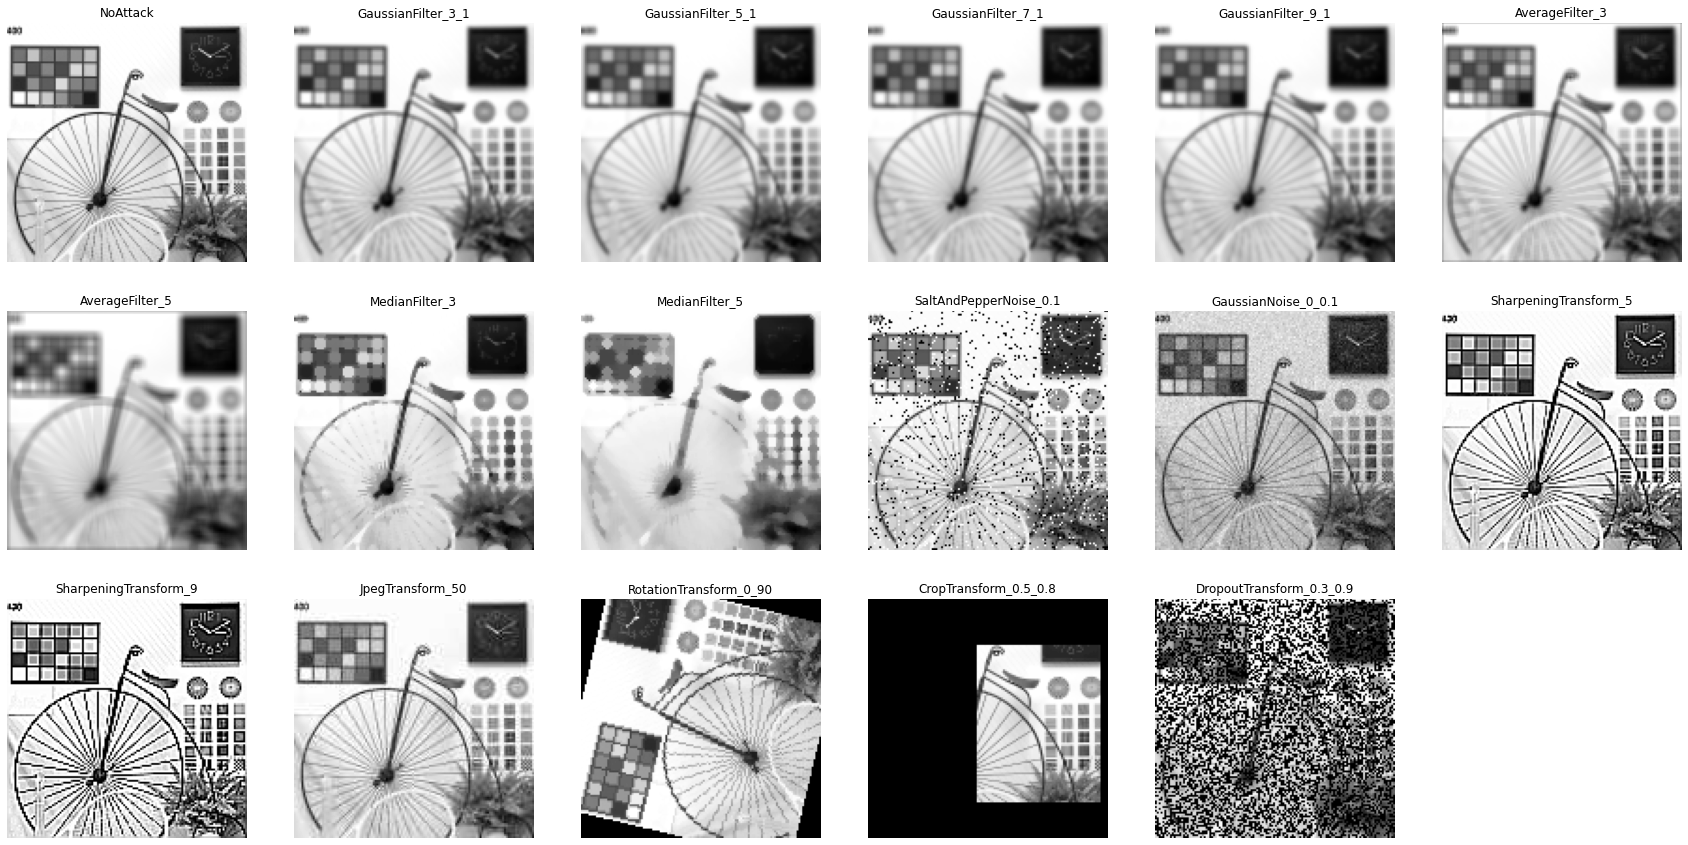

In [21]:
batch = Center()(IMGS_TEST[:]).to(get_device())[:,None,:,:].float()
attacked = [att(batch) for att in ATTACKS]

idx = np.random.randint(len(batch))
plt.figure(figsize=(30,15))
for i,a in enumerate(attacked):
    plt.subplot(3,6,i+1)
    plt.title(ATTACKS[i].name())
    plt.imshow(simp(attacked[i])[idx], cmap='gray')
    plt.axis('off')
plt.show()

## Define Datasets

In [22]:
class MyDataset(torch.utils.data.Dataset):
    """Simple dataset for train and test data.
    Image values are convert into [-1,1]."""
    def __init__(self, root, transform=Center()):
        if root == "Train":
            self.imgs = IMGS_TRAIN
        else:
            self.imgs = IMGS_TEST
        
        self.transform = transform

    def __getitem__(self, idx):
        return self.transform(self.imgs[idx])

    def __len__(self):
        return len(self.imgs)

In [23]:
# Datasets
train_data = MyDataset("Train")
test_data = MyDataset("Test")

In [24]:
# Dataloaders
batch_size = 30 # 100 in the paper, but best I can do is 30...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

### Image and mark sample

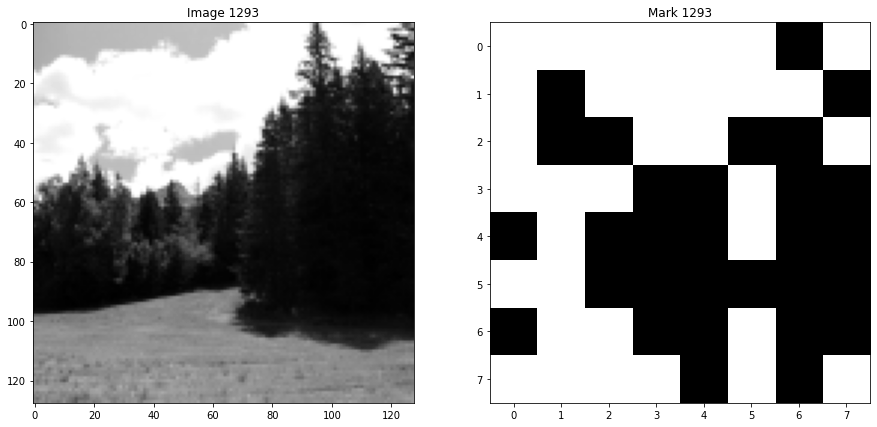

In [25]:
# Plot a random example from training dataset
idx = np.random.randint(len(train_data))
img = train_data[idx]
mark = generate_mark()
show_img_mark(img, mark, idx)

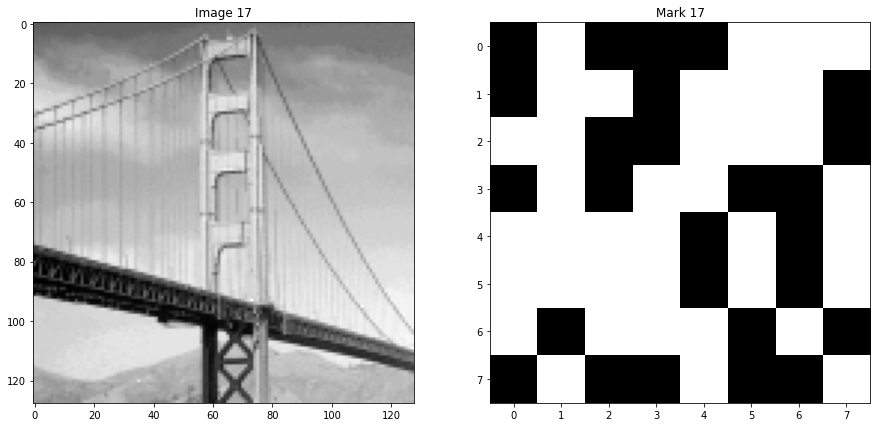

In [26]:
# Plot a random example from testing dataset
idx = np.random.randint(len(test_data))
img = test_data[idx]
mark = generate_mark()
show_img_mark(img, mark, idx)

## Define Model

In [27]:
class HostPreProcess(nn.Module):
    """Pre processing of the host image."""
    def __init__(self):
        super().__init__()
        self.preprocess = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        return self.preprocess(x)

class WMPreProcess(nn.Module):
    """Pre processing of the watermark."""
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1, out_channels=512, kernel_size=3, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=1),

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=1),

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=1),

            nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size=3, stride=2),
            nn.AvgPool2d(2, stride=1),
        )

    def forward(self, x):
        return self.layers(x)

class EmbeddingNetwork(nn.Module):
    """Creation of the watermarked image, from the preprocessed host image and watermark."""
    def __init__(self, strength=1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=65, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
        )

        self.strength = strength

    def forward(self, img, mark):
        x = torch.cat((mark*self.strength, img), 1)
        return self.layers(x)
    
class Watermarking(nn.Module):
    """Gather preprocessing networks and embedding:
    from host image and watermark, returns the watermarked image."""
    def __init__(self, strength=1):
        super().__init__()
        self.host_pre_process = HostPreProcess()
        self.wm_pre_process = WMPreProcess()
        self.embedding = EmbeddingNetwork(strength=strength)

    def forward(self, img, mark):
        img_processed = self.host_pre_process(img)
        mark_processed = self.wm_pre_process(mark)
        return self.embedding(img_processed, mark_processed)

class WatermarkExtactor(nn.Module):
    """Extract the watermark from the watermarked image."""
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=2, stride=2),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.layers(x)

### Initialize the models ###
model_watermark = Watermarking()
model_extraction = WatermarkExtactor()

In [28]:
# Set GPU or CPU device
device = get_device()
print("Device:", device)
model_watermark.to(device)
model_extraction.to(device)

# Sum up models
print("Watermark Network")
summary(model_watermark, [(1,128,128), (1,8,8)])
print("\n\nWatermark Extraction Network")
summary(model_extraction, (1,128,128))

Device: cuda:0
Watermark Network
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
    HostPreProcess-2         [-1, 64, 128, 128]               0
   ConvTranspose2d-3          [-1, 512, 17, 17]           5,120
       BatchNorm2d-4          [-1, 512, 17, 17]           1,024
              ReLU-5          [-1, 512, 17, 17]               0
         AvgPool2d-6          [-1, 512, 16, 16]               0
   ConvTranspose2d-7          [-1, 256, 33, 33]       1,179,904
       BatchNorm2d-8          [-1, 256, 33, 33]             512
              ReLU-9          [-1, 256, 33, 33]               0
        AvgPool2d-10          [-1, 256, 32, 32]               0
  ConvTranspose2d-11          [-1, 128, 65, 65]         295,040
      BatchNorm2d-12          [-1, 128, 65, 65]             256
             ReLU-13          [-1, 128, 65, 65]               0
      

### Check model update

Some functions and a context manager that were used during training to verify which model weights and/or gradients is updated.

In [29]:
def grad_ext():
    if model_extraction.layers[0].weight.grad == None:
        return 0
    return model_extraction.layers[0].weight.grad.sum().item()

def grad_emb():
    if model_watermark.host_pre_process.preprocess.weight.grad == None:
        return 0
    return model_watermark.host_pre_process.preprocess.weight.grad.sum().item()
def weight_ext():
    if model_extraction.layers[0].weight == None:
        return 0
    return model_extraction.layers[0].weight.sum().item()

def weight_emb():
    if model_watermark.host_pre_process.preprocess.weight == None:
        return 0
    return model_watermark.host_pre_process.preprocess.weight.sum().item()


class getUpdate(object):
    def __init__(self, title="", active=True):
        self.active = active
        if self.active:
            print("\n"+title)

    def __enter__(self, *args):
        if self.active:
            self.ext_grad, self.emb_grad = grad_ext(), grad_emb()
            self.ext_weight, self.emb_weight = weight_ext(), weight_emb()
  
    def __exit__(self, *args):
        if self.active:
            print("- Embedding gradients changed.\n"*(self.emb_grad != grad_emb()), end="")
            print("- Extraction gradients changed.\n"*(self.ext_grad != grad_ext()), end="")
            print("- Embedding weights changed.\n"*(self.emb_weight != weight_emb()), end="")
            print("- Extraction weights changed.\n"*(self.ext_weight != weight_ext()), end="")

## Training

### Loss & Optimizer

In [30]:
# Lambdas
lmb1 = 45
lmb2 = 0.2
lmb3 = 20

# Loss function
criterion_emb = nn.MSELoss()
criterion_ext = nn.L1Loss()

# Optimizer
optimizer_emb = torch.optim.Adam(model_watermark.parameters(), lr=0.0001)
optimizer_ext = torch.optim.Adam(model_extraction.parameters(), lr=0.00001)

### Training Process

In [31]:
# Initilialize losses log
loss_emb = []
loss_ext = []

# Set saving path
PATH_MODEL = 'Model/test_last.pth'

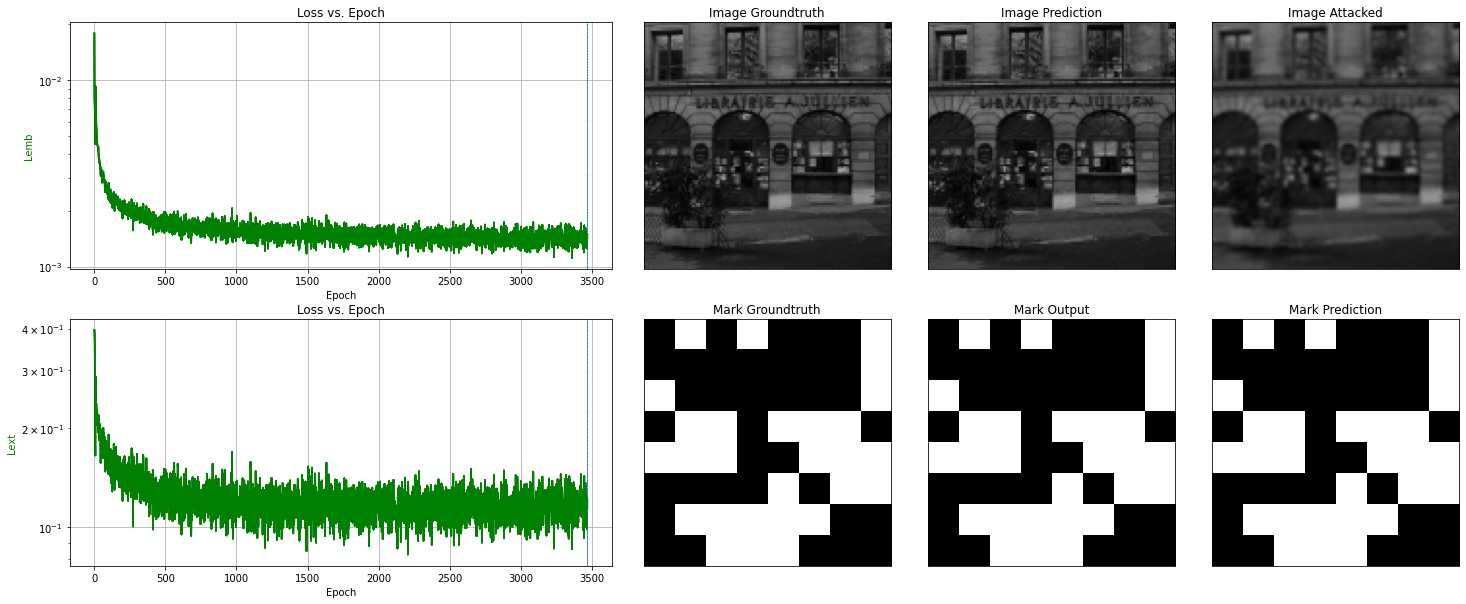

In [59]:
# Epochs and parameters
n_epochs = 1
n_save = 5
n_plot = 1
n = len(loss_emb)

# Plot layout
axs = get_plot_layout()

# Mode train
model_watermark.train()
model_extraction.train()

# Debbug tool
active = False

# Train the models
for epoch in range(n+1, n+n_epochs+1):
    # monitor training loss
    _loss_emb = 0.0
    _loss_ext = 0.0

    # Training for each batch
    pbar = tqdm(train_loader, leave=False, position=0)
    for images in pbar:
        pbar.set_description(f"Epoch {epoch}/{n+n_epochs}")

        # Retrieve data batch
        marks = get_mark_batch(images.shape[0])
        images = images.to(device)[:,None,:,:].float()
        marks = marks.to(device)[:,None,:,:].float()

        # Initialize gradients
        optimizer_emb.zero_grad()
        optimizer_ext.zero_grad()

        # Image reconstruction loss
        outputs_1 = model_watermark(images, marks)
        L1 = criterion_emb(outputs_1, images)

        # Attack output images
        attacked_images, _attack = attack(outputs_1)

        # Mark reconstruction loss
        outputs_2 = model_extraction(attacked_images)
        L2 = criterion_ext(outputs_2, marks)

        # Network models losses
        Lemb = lmb1*L1 + lmb2*L2
        Lext = lmb3*L2

        # Update gradients
        with getUpdate("Lemb backward", active=active):
            Lemb.backward(retain_graph=True, inputs=list(model_watermark.parameters()))
        with getUpdate("Lext backward", active=active):
            Lext.backward(inputs=list(model_extraction.parameters()))

        # Update weights
        with getUpdate("emb optimizer", active=active):
            optimizer_emb.step()
        with getUpdate("ext optimizer", active=active):
            optimizer_ext.step()

        # Update loss
        _loss_emb += Lemb.item()
        _loss_ext += Lext.item()

    # Save loss
    loss_emb.append(_loss_emb / len(train_data))
    loss_ext.append(_loss_ext / len(train_data))

    # Plot loss & example from last outputs
    if epoch % n_plot == 0 or epoch == n+n_epochs:
        display_plot(axs, n, loss_emb, loss_ext, images, outputs_1, attacked_images, marks, outputs_2)
        print("Attack = ", _attack)

    # Save the model
    if epoch % n_save == 0 or epoch == n+n_epochs:
        torch.save({
                'epoch': epoch,

                'model_state_dict_emb': model_watermark.state_dict(),
                'optimizer_state_dict_emb': optimizer_emb.state_dict(),
                'loss_emb': loss_emb,

                'model_state_dict_ext': model_extraction.state_dict(),
                'optimizer_state_dict_ext': optimizer_ext.state_dict(),
                'loss_ext': loss_ext,
                }, PATH_MODEL)

display.clear_output()

### Load models

In [32]:
### Load a model (such as the training can be resume) ###

# Embedding part init
model_watermark = Watermarking()
model_watermark.to(device)
optimizer_emb = torch.optim.Adam(model_watermark.parameters(), lr=0.0001)

# Extraction part init
model_extraction = WatermarkExtactor()
model_extraction.to(device)
optimizer_ext = torch.optim.Adam(model_extraction.parameters(), lr=0.00001)

# Load everything
checkpoint = torch.load(PATH_MODEL, map_location=device)
epoch = checkpoint['epoch']

model_watermark.load_state_dict(checkpoint['model_state_dict_emb'])
optimizer_emb.load_state_dict(checkpoint['optimizer_state_dict_emb'])
loss_emb = checkpoint['loss_emb']

model_extraction.load_state_dict(checkpoint['model_state_dict_ext'])
optimizer_ext.load_state_dict(checkpoint['optimizer_state_dict_ext'])
loss_ext = checkpoint['loss_ext']

print("Last epoch:", epoch)

Last epoch: 3465


## Evaluation

### Sample results from test dataset

In [39]:
model_watermark.eval()
model_extraction.eval()

Nsamp = 15
sample_idx = torch.randint(len(test_data), size=(Nsamp,))

images = [test_data[i] for i in sample_idx]
images = torch.stack(images)
marks = get_mark_batch(images.shape[0], same_mark=False)

# Watermarking process and mark extraction
images_cuda = images[:,None,:,:].to(device).float()
marks_cuda = marks[:,None,:,:].to(device).float()
reconstructed_images = model_watermark(images_cuda, marks_cuda)
reconstructed_marks = model_extraction(reconstructed_images)

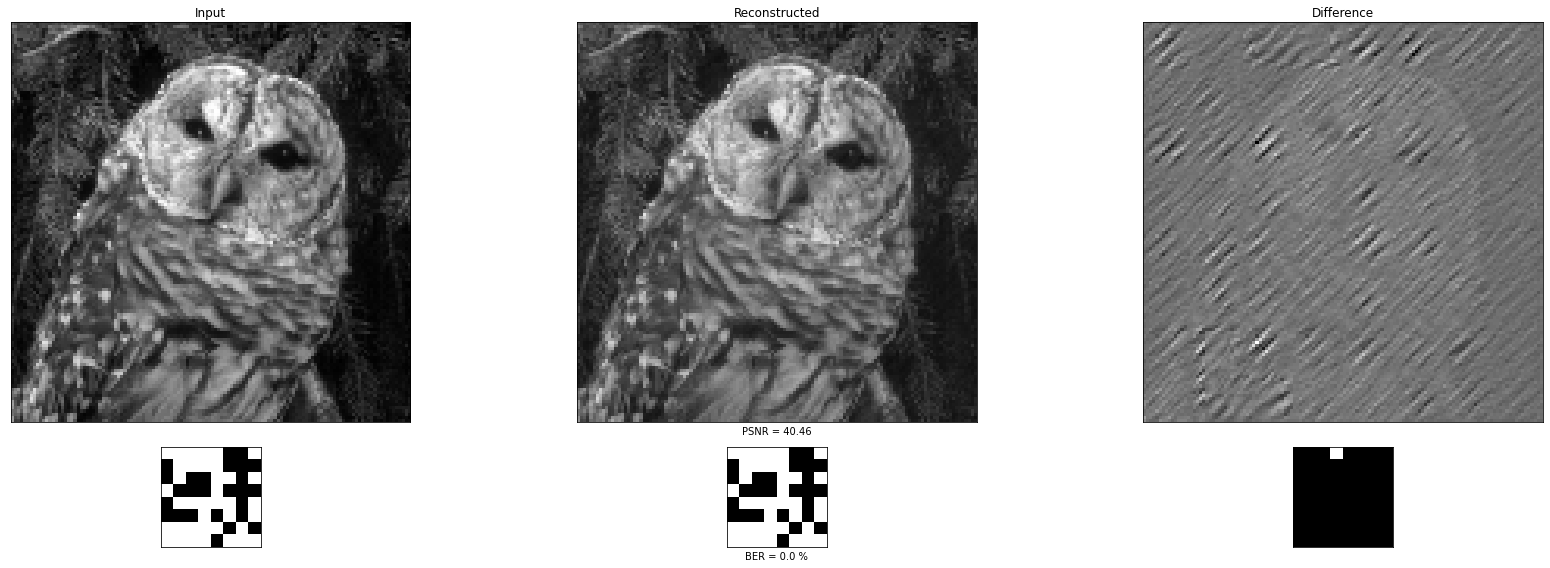

In [40]:
idx = np.random.randint(len(images))

fig, ax = plt.subplots(2, 3, gridspec_kw={'height_ratios': [4,1]}, figsize=(25,8))

ax[0,0].set_title("Input")
ax[0,0].imshow(images[idx], cmap='gray')
ax[1,0].imshow(marks[idx], cmap='gray')

rec_image  = simp(reconstructed_images[idx])
rec_mark  = simp(reconstructed_marks[idx])

ax[0,1].set_title("Reconstructed")
ax[0,1].imshow(rec_image, cmap='gray', vmin=-1, vmax=1)
ax[0,1].set_xlabel(f'PSNR = {psnr(images[idx].numpy(), rec_image):.2f}')

ax[1,1].imshow(rec_mark, cmap='gray', vmin=-1, vmax=1)
ax[1,1].set_xlabel(f'BER = {BER(marks[idx].numpy(), rec_mark):.1f} %')

ax[0,2].set_title("Difference")
ax[0,2].imshow(images[idx].numpy()-rec_image, cmap='gray')
ax[1,2].imshow(marks[idx].numpy()-rec_mark, cmap='gray')

for a in ax.ravel():
    a.set_yticklabels([]), a.set_xticks([])
    a.set_xticklabels([]), a.set_yticks([])
fig.tight_layout()

### Invisibility

In [56]:
N_repeats = 100
data = test_data[:]
images_cuda = data[:,None,:,:].to(device).float()

model_watermark.eval()

results = []
for _ in range(N_repeats):
    marks = get_mark_batch(data.shape[0], same_mark=False)
    marks_cuda = marks[:,None,:,:].to(device).float()
    rec_images = simp(model_watermark(images_cuda, marks_cuda))

    results.append([psnr(im.numpy(),rec) for (im, rec) in zip(data, rec_images)])
results = np.array(results)


results_psnr = pd.DataFrame({
    "Min PSNR (%)": results.min(axis=0),
    "Mean PSNR (%)": results.mean(axis=0),
    "Max PSNR (%)": results.max(axis=0),
})

results_psnr.loc["All"] = [results.min(), results.mean(), results.max()]

results_psnr

,Min PSNR (%),Mean PSNR (%),Max PSNR (%)
0,40.297243,40.994479,41.802134
1,39.020709,39.420722,39.882815
2,37.876414,38.384890,39.013947
3,41.290784,41.864013,42.496216
4,39.534362,39.873021,40.302770
5,40.710169,41.526594,42.137704
6,41.297334,42.256128,43.059744
7,40.624033,41.304635,41.973987
8,39.673126,40.289524,41.103302
9,40.615374,41.366670,42.113496


### Robustness

In [48]:
N_repeats = 10
data = test_data[:]

EVALATTACKS = [ NoAttack(),
                GaussianFilter(w=3),
                GaussianFilter(w=5),
                GaussianFilter(w=7),
                GaussianFilter(w=9),
                AverageFilter(w=3),
                AverageFilter(w=5),
                MedianFilter(w=3),
                MedianFilter(w=5),
                SaltAndPepperNoise(p=0.01),
                GaussianNoise(σ=0.01),
                JpegTransform(quality=50),
                RotationTransform(ang_min=45, ang_max=45),
                CropTransform(pmin=0.7, pmax=0.7), # Corresponds to 0.5 in the paper
                DropoutTransform(pmin=0.7, pmax=0.7),
            ]

BER_results = np.zeros((len(EVALATTACKS),3))

for i in range(len(EVALATTACKS)):
    _res = []
    for _ in range(N_repeats):
        _res += evaluation(data, EVALATTACKS[i], model_watermark, model_extraction)
    _res = np.array(_res)
    BER_results[i] =  _res.min(), _res.mean(), _res.max()

results_ber = pd.DataFrame({
    "Attack": [a.name() for a in EVALATTACKS],
    "Min BER (%)": BER_results[:,0],
    "Mean BER (%)": BER_results[:,1],
    "Max BER (%)": BER_results[:,2],
})

results_ber

,Attack,Min BER (%),Mean BER (%),Max BER (%)
0,NoAttack,0.0000,0.248724,6.2500
1,GaussianFilter_3_1,0.0000,2.777423,12.5000
2,GaussianFilter_5_1,0.0000,4.614158,17.1875
3,GaussianFilter_7_1,0.0000,4.534439,17.1875
4,GaussianFilter_9_1,0.0000,4.467474,14.0625
5,AverageFilter_3,0.0000,5.385842,18.7500
6,AverageFilter_5,1.5625,20.338010,45.3125
7,MedianFilter_3,0.0000,6.495536,18.7500
8,MedianFilter_5,7.8125,25.044643,42.1875
9,SaltAndPepperNoise_0.01,0.0000,0.373087,6.2500


## Watermark encoding

### Analyse

In [68]:
# Apply the watermarking process & extraction on the test dataset
model_watermark.eval()
model_extraction.eval()

images = test_data[:]
marks = get_mark_batch(images.shape[0], same_mark=False)

images_cuda = images[:,None,:,:].to(device).float()
marks_cuda = marks[:,None,:,:].to(device).float()
reconstructed_images = model_watermark(images_cuda, marks_cuda)
reconstructed_marks = model_extraction(reconstructed_images)

images = simp(images)
marks = simp(marks)
rec_images = simp(reconstructed_images)
rec_marks = simp(reconstructed_marks)

# Also compute differences between gt and pred for images and marks
diff_images = images-rec_images
diff_marks = marks-rec_marks

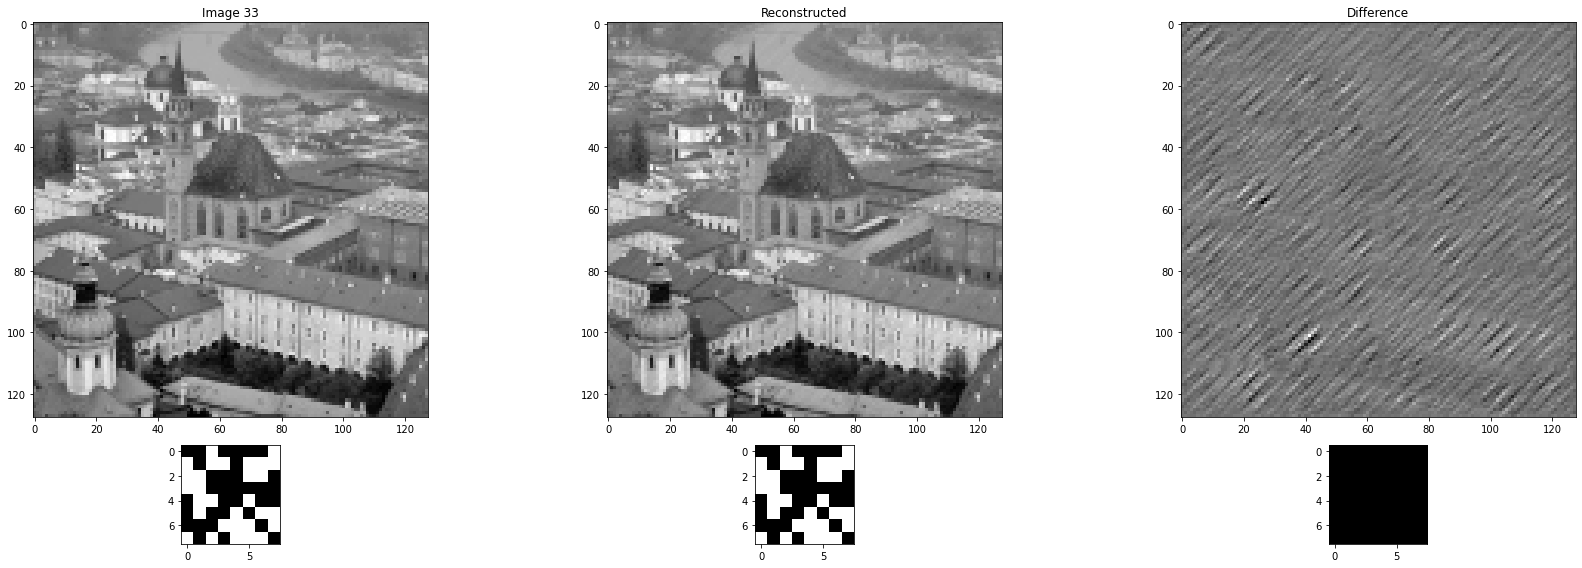

In [69]:
# Display randomly a result
idx = np.random.randint(len(images))

fig, ax = plt.subplots(2, 3, gridspec_kw={'height_ratios': [4,1]}, figsize=(25,8))

ax[0,0].set_title(f"Image {idx}")
ax[0,0].imshow(images[idx], cmap='gray')
ax[1,0].imshow(marks[idx], cmap='gray')

ax[0,1].set_title("Reconstructed")
ax[0,1].imshow(rec_images[idx], cmap='gray')
ax[1,1].imshow(rec_marks[idx], cmap='gray')

ax[0,2].set_title("Difference")
ax[0,2].imshow(diff_images[idx], cmap='gray')
ax[1,2].imshow(diff_marks[idx], cmap='gray')

fig.tight_layout()

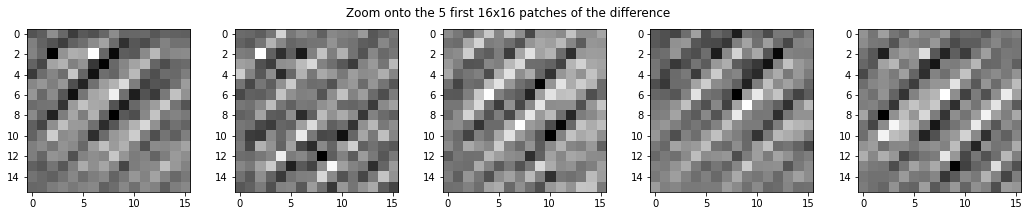

In [70]:
plt.figure(figsize=(18,3))
plt.suptitle("Zoom onto the 5 first 16x16 patches of the difference")
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(diff_images[idx][16*i:16*(i+1),:16], cmap='gray')
plt.show()

In [71]:
# Retrieve all 16x16 patches difference images
def to_patches(img):
    patches = []
    for i in range(8):
        for j in range(8):
            patches.append(img[16*i:16*(i+1),16*j:16*(j+1)].flatten())
    return patches

patches = []
for im in diff_images:
    patches += to_patches(im)
patches = np.array(patches)

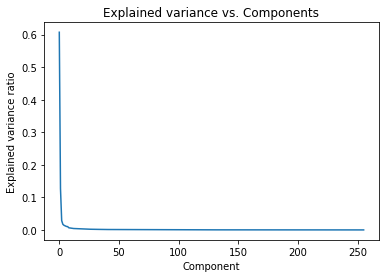

In [72]:
# PCA on all those patches
pca_all = PCA().fit(patches)

plt.figure()
plt.title("Explained variance vs. Components")
plt.plot(pca_all.explained_variance_ratio_)
plt.xlabel('Component')
plt.ylabel('Explained variance ratio')
plt.show()

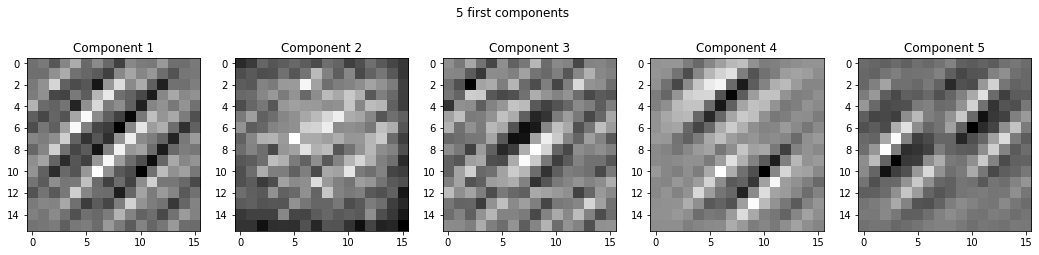

In [73]:
# First 5 components 
plt.figure(figsize=(18,4))
plt.suptitle("5 first components")
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.title(f"Component {i+1}")
    plt.imshow(pca_all.components_[i].reshape((16,16)), cmap='gray')
plt.show()

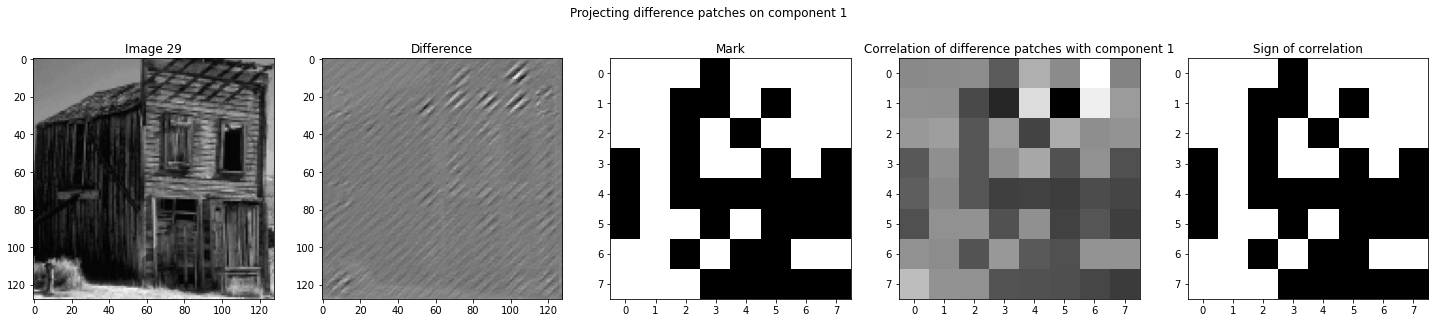

In [74]:
# Project the patches of a difference image onto the 1st component
idx = np.random.randint(len(images))
i_comp = 0

plt.figure(figsize=(25,5))
plt.suptitle(f"Projecting difference patches on component {i_comp+1}")

plt.subplot(151)
plt.title(f"Image {idx}")
plt.imshow(images[idx], cmap='gray')
plt.subplot(152)
plt.title("Difference")
plt.imshow(diff_images[idx], cmap='gray')
plt.subplot(153)
plt.title("Mark")
plt.imshow(marks[idx], cmap='gray')

proj = (to_patches(diff_images[idx]) @ pca_all.components_[i_comp]).reshape((8,8))
plt.subplot(154)
plt.title(f"Correlation of difference patches with component {i_comp+1}")
plt.imshow(proj, cmap='gray')
plt.subplot(155)
plt.title(f"Sign of correlation")
plt.imshow(proj>0, cmap='gray')

plt.show()

Thus, the watermark information seems to be added to the image as 16x16 patches with each patch corresponding to the bit a the "same" location. Those patches corresponds to the extracted commponent multiplied by a positive or negative factor, according to the sign of the bit. 

### Attack

We try to implement an attack that takes advantage of the previous analysis, and the knowledge of the component encoding the watermark. Thus, this attack remove the component of each 16x16 patches of the watermarked image, with a scalar factor that corresponds to correlation of the pacth with the component.

In [77]:
class ComponentAttack(object):
    def __init__(self, component):
        self.comp = torch.Tensor(component).to(get_device())

    def __call__(self, x):
        att_x = torch.zeros_like(x)
        for k in range(x.shape[0]):
            for i in range(8):
                for j in range(8):
                    patch = x[k,:,16*i:16*(i+1),16*j:16*(j+1)]
                    att_x[k,:,16*i:16*(i+1),16*j:16*(j+1)] = patch - torch.dot(patch.flatten(),self.comp)*self.comp.reshape((16,16))
        return att_x
    
    def name(self):
        return "ComponentAttack"

In [82]:
# Test the proposed atttack
comp_attack = ComponentAttack(pca_all.components_[i_comp])

model_watermark.eval()
model_extraction.eval()

images = test_data[:].repeat((2,1,1))
marks = get_mark_batch(images.shape[0], same_mark=False)

images_cuda = images[:,None,:,:].to(device).float()
marks_cuda = marks[:,None,:,:].to(device).float()

reconstructed_images = model_watermark(images_cuda, marks_cuda)
attacked_images = comp_attack(reconstructed_images)

reconstructed_marks = model_extraction(reconstructed_images)
reconstructed_marks_att = model_extraction(attacked_images)

images = simp(images)
att_imgs = simp(attacked_images)
marks = simp(marks)

rec_images = simp(reconstructed_images)
att_marks = simp(reconstructed_marks_att)
rec_marks = simp(reconstructed_marks)

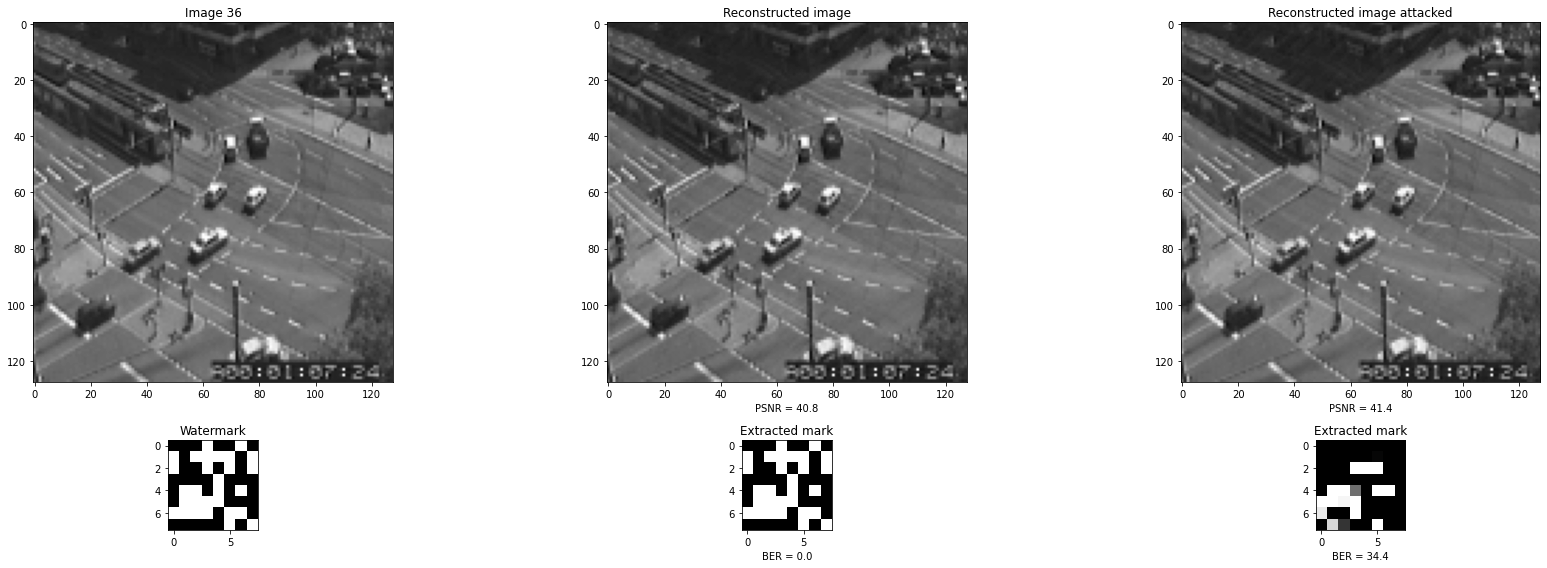

In [85]:
# Display an example from the results
idx = np.random.randint(len(images))

fig, ax = plt.subplots(2, 3, gridspec_kw={'height_ratios': [4,1]}, figsize=(25,8))

ax[0,0].set_title(f"Image {idx}")
ax[0,0].imshow(images[idx], cmap='gray')
ax[1,0].set_title("Watermark")
ax[1,0].imshow(marks[idx], cmap='gray')

ax[0,1].set_title("Reconstructed image")
ax[0,1].imshow(rec_images[idx], cmap='gray')
ax[0,1].set_xlabel(f"PSNR = {psnr(images[idx], rec_images[idx]):.1f}")
ax[1,1].set_title("Extracted mark")
ax[1,1].imshow(rec_marks[idx], cmap='gray')
ax[1,1].set_xlabel(f"BER = {BER(marks[idx], rec_marks[idx]):.1f}")

ax[0,2].set_title("Reconstructed image attacked")
ax[0,2].imshow(att_imgs[idx], cmap='gray')
ax[0,2].set_xlabel(f"PSNR = {psnr(images[idx], att_imgs[idx]):.1f}")
ax[1,2].set_title("Extracted mark")
ax[1,2].imshow(att_marks[idx], cmap='gray')
ax[1,2].set_xlabel(f"BER = {BER(marks[idx], att_marks[idx]):.1f}")

fig.tight_layout()

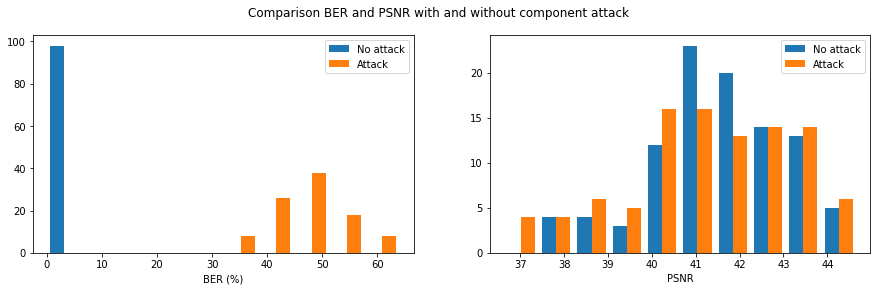

In [84]:
# We look at the psnr and ber results
bers_rec = [BER(marks[i], rec_marks[i]) for i in range(len(marks))]
bers_att = [BER(marks[i], att_marks[i]) for i in range(len(marks))]
psnrs_rec = [psnr(images[i], rec_images[i]) for i in range(len(images))]
psnrs_att = [psnr(images[i], att_imgs[i]) for i in range(len(images))]

plt.figure(figsize=(15,4))
plt.suptitle("Comparison BER and PSNR with and without component attack")
plt.subplot(121)
plt.hist([bers_rec,bers_att], label=['No attack', 'Attack'])
plt.xlabel("BER (%)")
plt.legend()

plt.subplot(122)
plt.hist([psnrs_rec,psnrs_att], label=['No attack', 'Attack'])
plt.xlabel("PSNR")
plt.legend()
plt.show()